In [1]:
# for use in tutorial and development; do not include this `sys.path` change in production:
import sys ; sys.path.insert(0, "../")
import os ; from os.path import dirname

# Statistical Relational Learning with `pslpython`

In this section we'll explore one form of 
[*statistical relational learning*](../glossary/#statistical-relational-learning)
called 
[*probabilistic soft logic*](../glossary/#probabilistic-soft-logic) (PSL).

One of the examples given for PSL is called [*simple acquaintances*](https://github.com/linqs/psl-examples/tree/master/simple-acquaintances), which uses a graph of some friends, where they live, what interests they share, and then infers who probably knows whom.
Some people explicitly do or do not know each other, while other "knows" relations can be inferred based on whether two people have lived in the same place or share common interest.

The objective is to build a PSL model for [*link prediction*](https://en.wikipedia.org/wiki/Link_prediction), to evaluate the annotations in the friend graph.
In this case, we'll assume that the "knows" relations have been added from a questionable source (e.g., some third-party dataset) so we'll measure a subset of these relations and determine their likelihood.
NB: this is really useful for cleaning up annotations in a large graph!

Now let's load a KG which is an RDF representation of this "simple acquaintances" example, based on using the [`foaf`](http://www.foaf-project.org/) vocabulary:

In [2]:
import kglab

namespaces = {
    "acq":  "http://example.org/stuff/",
    "foaf": "http://xmlns.com/foaf/0.1/",
    }

kg = kglab.KnowledgeGraph(
    name = "LINQS simple acquaintance example for PSL",
    base_uri = "http://example.org/stuff/",
    namespaces = namespaces,
    )

kg.load_rdf(dirname(os.getcwd()) + "/dat/acq.ttl")

Take a look at the `dat/acq.ttl` file to see the people and their relations.
Here's a quick visualization of the graph:

In [3]:
VIS_STYLE = {
    "foaf": {
        "color": "orange",
        "size": 5,
    },
    "acq":{
        "color": "blue",
        "size": 30,
    },
}

excludes = [
    kg.get_ns("rdf").type,
    kg.get_ns("rdfs").domain,
    kg.get_ns("rdfs").range,
]

subgraph = kglab.SubgraphTensor(kg, excludes=excludes)
pyvis_graph = subgraph.build_pyvis_graph(notebook=True, style=VIS_STYLE)

pyvis_graph.force_atlas_2based()
pyvis_graph.show("tmp.fig04.html")

## Loading a PSL model

Next, we'll use the [`pslpython`](https://pypi.org/project/pslpython/) library implemented in Python (atop its core library running in Java) to define three *predicates* (i.e., relations – similar as in RDF) which are: `Neighbors`, `Likes`, `Knows`

In [4]:
psl = kglab.PSLModel(
    name = "simple acquaintances",
    )

Then add each of the predicates:

In [5]:
psl.add_predicate("Lived", size=2)
psl.add_predicate("Likes", size=2)
psl.add_predicate("Knows", size=2, closed=False)

Next, we'll add a set of probabilistic [*rules*](https://psl.linqs.org/wiki/2.2.1/Rule-Specification.html), all with different weights applied:

  1. "Two people who live in the same place are **more** likely to know each other"
  2. "Two people who don't live in the same place are **less** likely to know each other"
  3. "Two people who share a common interest are **more** likely to know each other"
  4. "Two people who both know a third person are **more** likely to know each other"
  5. "Otherwise, any pair of people are **less** likely to know each other"

In [6]:
psl.add_rule("Lived(P1, L) & Lived(P2, L) & (P1 != P2) -> Knows(P1, P2)", weight=20.0, squared=True)

psl.add_rule("Lived(P1, L1) & Lived(P2, L2) & (P1 != P2) & (L1 != L2) -> !Knows(P1, P2)", weight=5.0, squared=True)

psl.add_rule("Likes(P1, L) & Likes(P2, L) & (P1 != P2) -> Knows(P1, P2)", weight=10.0, squared=True)

psl.add_rule("Knows(P1, P2) & Knows(P2, P3) & (P1 != P3) -> Knows(P1, P3)", weight=5.0, squared=True)

psl.add_rule("!Knows(P1, P2)", weight=5.0, squared=True)

Finally we'll add a [*commutative*](https://mathworld.wolfram.com/Commutative.html) rule such that:
> "If Person 1 knows Person 2, then Person 2 also knows Person 1."

In [7]:
psl.add_rule("Knows(P1, P2) = Knows(P2, P1)", weighted=False)

To initialize the model, we'll clear any pre-existing data for each of the predicates:

In [8]:
psl.clear_model()

Next we'll create a specific `Subgraph` to transform the names of `foaf:Person` in the graph, since the PSL rules in this example focus on relations among the people:

In [9]:
people_iter = kg.rdf_graph().subjects(kg.get_ns("rdf").type, kg.get_ns("foaf").Person)
people_nodes = [ p for p in sorted(people_iter, key=lambda p: str(p)) ]

subgraph_people = kglab.Subgraph(kg, preload=people_nodes)

The locations are hard-coded here, so that we can compare with results from the PSL sample code.

In [10]:
import rdflib

locale_nodes = [
    rdflib.term.URIRef('http://example.org/stuff/Santa_Cruz'),
    rdflib.term.URIRef('http://example.org/stuff/Maryland'),
    rdflib.term.URIRef('http://example.org/stuff/Seattle'),
    rdflib.term.URIRef('http://example.org/stuff/Los_Gatos'),
    rdflib.term.URIRef('http://example.org/stuff/Los_Altos'),
    ]

In [11]:
#locale_iter = kg.rdf_graph().objects(None, kg.get_ns("foaf").based_near)
#locale_nodes = sorted(list({ l for l in sorted(locale_iter, key=lambda l: l) }))

subgraph_locale = kglab.Subgraph(kg, preload=locale_nodes)

Now let's query our KG to populate data into the `Liked` predicate in the PSL model, based on `foaf:based_near` which represents people who live nearby each other:

In [12]:
sparql = """
SELECT DISTINCT ?p1 ?l
  WHERE {
    ?p1 foaf:based_near ?l
  }
"""

for row in kg.query(sparql):
    #print(row)
    p1 = subgraph_people.transform(row.p1)
    l = subgraph_locale.transform(row.l)
    #print(p1, l)
    psl.add_data_row("Lived", [p1, l])

Note: these data points are *observations*, i.e., empirical support for the probabilistic model.

In [13]:
df = psl.trace_predicate("Lived", partition="observations")
df

,P1,P2,value
0,0,4,1.0
1,1,0,1.0
2,1,4,1.0
3,2,2,1.0
4,2,4,1.0
5,3,0,1.0
6,3,1,1.0
7,3,2,1.0
8,3,3,1.0
9,4,0,1.0


In [14]:
import pathlib

trace_path = pathlib.Path("lived_obs.tsv")
df_known = psl.compare_predicate(df, trace_path)

---

In [15]:
likes_nodes = [
    rdflib.term.URIRef('http://example.org/stuff/Machine_Learning'),
    rdflib.term.URIRef('http://example.org/stuff/Futball'),
    rdflib.term.URIRef('http://example.org/stuff/Chess'),
    rdflib.term.URIRef('http://example.org/stuff/Super_Smash_Brothers_Melee'),
    rdflib.term.URIRef('http://example.org/stuff/Badminton'),
    rdflib.term.URIRef('http://example.org/stuff/Surfing'),
    rdflib.term.URIRef('http://example.org/stuff/Hiking'),
    rdflib.term.URIRef('http://example.org/stuff/Programming'),
    rdflib.term.URIRef('http://example.org/stuff/Photography'),
    rdflib.term.URIRef('http://example.org/stuff/Running'),
]

In [16]:
subgraph_likes = kglab.Subgraph(kg, preload=likes_nodes)

Next let's query our KG to populate data into the `Likes` predicate in the PSL model, based on shared interests in `foaf:topic_interest` topics:

In [17]:
sparql = """
SELECT DISTINCT ?p1 ?t
  WHERE {
    ?p1 foaf:topic_interest ?t
  }
  """

for row in kg.query(sparql):
    p1 = subgraph_people.transform(row.p1)
    t = subgraph_likes.transform(row.t)
    psl.add_data_row("Likes", [p1, t])  # anchoring PR discussion

In [18]:
df = psl.trace_predicate("Likes", partition="observations")
df

,P1,P2,value
0,0,0,1.0
1,0,1,1.0
2,0,2,1.0
3,0,4,1.0
4,0,5,1.0
...,...,...,...
127,24,3,1.0
128,24,4,1.0
129,24,5,1.0
130,24,7,1.0


In [19]:
trace_path = pathlib.Path("likes_obs.tsv")
df_known = psl.compare_predicate(df, trace_path)

 expected   P1 P2  value
0  0  0    1.0
 expected   P1 P2  value
1  0  1    1.0
 expected   P1 P2  value
2  0  2    1.0
 error 0 3 0.17649495639106194
 expected   P1 P2  value
3  0  4    1.0
 expected   P1 P2  value
4  0  5    1.0
 error 0 6 0.4181148142791115
 error 0 7 0.3412389183817482
 error 0 8 0.4112253482165464
 expected   P1 P2  value
5  0  9    1.0
 expected   P1 P2  value
6  1  0    1.0
 expected   P1 P2  value
7  1  1    1.0
 error 1 2 0.0478506511751029
 error 1 3 0.20633921372014008
 error 1 4 0.4556123055182511
 expected   P1 P2  value
8  1  5    1.0
 expected   P1 P2  value
9  1  6    1.0
 expected    P1 P2  value
10  1  7    1.0
 expected    P1 P2  value
11  1  8    1.0
 error 1 9 0.3295654012558299
 expected    P1 P2  value
12  2  0    1.0
 expected    P1 P2  value
13  2  1    1.0
 error 2 2 0.409687776988767
 expected    P1 P2  value
14  2  3    1.0
 expected    P1 P2  value
15  2  4    1.0
 error 2 5 0.4906494121887
 expected    P1 P2  value
16  2  6    1.0
 error 2

In [20]:
df_known.head()

,P1,P2,value
0,0,0,0.579236
1,0,1,0.803467
2,0,2,0.619429
3,0,3,0.176495
4,0,4,0.806024


Just for kicks, let's take a look at the internal representation of a PSL predicate, which is a `pandas.DataFrame`:

In [21]:
predicate = psl.model.get_predicate("Likes")
predicate.__dict__

{'_types': [<ArgType.UNIQUE_STRING_ID: 'UniqueStringID'>,
  <ArgType.UNIQUE_STRING_ID: 'UniqueStringID'>],
 '_data': {<Partition.OBSERVATIONS: 'observations'>:       0  1    2
  0    19  3  1.0
  1     9  3  1.0
  2    12  9  1.0
  3    12  3  1.0
  4     0  9  1.0
  ..   .. ..  ...
  127   5  4  1.0
  128  10  5  1.0
  129  19  5  1.0
  130   0  5  1.0
  131  13  7  1.0
  
  [132 rows x 3 columns],
  <Partition.TARGETS: 'targets'>: Empty DataFrame
  Columns: [0, 1, 2]
  Index: [],
  <Partition.TRUTH: 'truth'>: Empty DataFrame
  Columns: [0, 1, 2]
  Index: []},
 '_name': 'LIKES',
 '_closed': False}

Now we'll load data from the `dat/psl/knows_targets.txt` CSV file, which is a list of `foaf:knows` relations in our graph that we want to analyze.
Each of these has an assumed value of `1.0` (true) or `0.0` (false).
Our PSL analysis will assign probabilities for each so that we can compare which annotations appear to be suspect and require further review:

In [22]:
import csv
import pandas as pd

targets = []
rows_list = []

with open(dirname(os.getcwd()) + "/dat/psl/knows_targets.txt", "r") as f:
    reader = csv.reader(f, delimiter="\t")
    
    for i, row in enumerate(reader):
        p1 = int(row[0])
        p2 = int(row[1])
        targets.append((p1, p2))
    
        p1_node = subgraph_people.inverse_transform(p1)
        p2_node = subgraph_people.inverse_transform(p2)
        
        if (p1_node, kg.get_ns("foaf").knows, p2_node) in kg.rdf_graph():
            truth = 1.0
            rows_list.append({ 0: p1, 1: p2, "truth": truth})

            psl.add_data_row("Knows", [p1, p2], partition="truth", truth_value=truth)
            psl.add_data_row("Knows", [p1, p2], partition="targets")

        elif (p1_node, kg.get_ns("acq").wantsIntro, p2_node) in kg.rdf_graph():
            truth = 0.0
            rows_list.append({ 0: p1, 1: p2, "truth": truth})

            psl.add_data_row("Knows", [p1, p2], partition="truth", truth_value=truth)
            psl.add_data_row("Knows", [p1, p2], partition="targets")

        else:
            print("UNKNOWN", p1, p2)

These data points are considered to be *ground atoms*, each with a *truth* value set initially.

In [23]:
df = psl.trace_predicate("Knows", partition="truth")
df

,P1,P2,value
0,0,1,1.0
1,0,7,1.0
2,0,15,1.0
3,0,18,1.0
4,0,22,0.0
...,...,...,...
113,22,24,1.0
114,23,0,1.0
115,23,2,1.0
116,23,9,1.0


In [24]:
trace_path = pathlib.Path("knows_tru.tsv")
df_known = psl.compare_predicate(df, trace_path)

In [25]:
df = psl.trace_predicate("Knows", partition="targets")
df

,P1,P2,value
0,0,1,1.0
1,0,7,1.0
2,0,15,1.0
3,0,18,1.0
4,0,22,1.0
...,...,...,...
113,22,24,1.0
114,23,0,1.0
115,23,2,1.0
116,23,9,1.0


In [26]:
trace_path = pathlib.Path("knows_tar.tsv")
df_known = psl.compare_predicate(df, trace_path)

These are also our *targets* for which nodes in the graph to analyze based on the rules.
We'll keep a dataframe called `df_dat` to preserve these values for later use:

In [27]:
df_dat = pd.DataFrame(rows_list)
df_dat.head()

,0,1,truth
0,0,1,1.0
1,0,7,1.0
2,0,15,1.0
3,0,18,1.0
4,0,22,0.0


Next, we'll add `foaf:knows` observations which are in the graph, although not among our set of targets.
This provides more evidence for the probabilistic inference.
Note that since RDF does not allow for representing probabilities on relations, we're using the `acq:wantsIntro` to represent a `foaf:knows` with a `0.0` probability:

In [28]:
sparql = """
SELECT ?p1 ?p2
  WHERE {
    ?p1 foaf:knows ?p2 .
  }
  ORDER BY ?p1 ?p2
  """

for row in kg.query(sparql):
    p1 = subgraph_people.transform(row.p1)
    p2 = subgraph_people.transform(row.p2)
    
    if (p1, p2) not in targets:
        psl.add_data_row("Knows", [p1, p2], truth_value=1.0)
    
sparql = """
SELECT ?p1 ?p2
  WHERE {
    ?p1 acq:wantsIntro ?p2 .
  }
  ORDER BY ?p1 ?p2
  """

for row in kg.query(sparql):
    p1 = subgraph_people.transform(row.p1)
    p2 = subgraph_people.transform(row.p2)
    
    if (p1, p2) not in targets:
        psl.add_data_row("Knows", [p1, p2], truth_value=0.0)

In [29]:
df = psl.trace_predicate("Knows", partition="observations")
df

,P1,P2,value
0,0,2,1.0
1,0,3,1.0
2,0,4,1.0
3,0,5,1.0
4,0,6,0.0
...,...,...,...
477,24,19,1.0
478,24,20,0.0
479,24,21,0.0
480,24,22,1.0


In [30]:
trace_path = pathlib.Path("knows_obs.tsv")
df_known = psl.compare_predicate(df, trace_path)

Now we're ready to run optimization on the PSL model and infer the *grounded atoms*.
This may take a few minutes to run:

In [31]:
psl.infer()

7045 [pslpython.model PSL] INFO --- 0    [main] INFO  org.linqs.psl.cli.Launcher  - Running PSL CLI Version 2.2.2-5f9a472
7385 [pslpython.model PSL] INFO --- 341  [main] INFO  org.linqs.psl.cli.Launcher  - Loading data
7637 [pslpython.model PSL] INFO --- 593  [main] INFO  org.linqs.psl.cli.Launcher  - Data loading complete
7638 [pslpython.model PSL] INFO --- 594  [main] INFO  org.linqs.psl.cli.Launcher  - Loading model from /var/folders/zz/2ffrqd5j7n52x67qd94h_r_h0000gp/T/psl-python/simple acquaintances/simple acquaintances.psl
7823 [pslpython.model PSL] INFO --- 779  [main] INFO  org.linqs.psl.cli.Launcher  - Model loading complete
7824 [pslpython.model PSL] INFO --- 779  [main] INFO  org.linqs.psl.cli.Launcher  - Starting inference with class: org.linqs.psl.application.inference.MPEInference
7971 [pslpython.model PSL] INFO --- 927  [main] INFO  org.linqs.psl.application.inference.MPEInference  - Grounding out model.
8387 [pslpython.model PSL] INFO --- 1343 [main] INFO  org.linqs.psl.

Let's examine the results.
We'll get a `pandas.DataFrame` describing the targets in the `Knows` predicate:

In [32]:
df = psl.get_results("Knows")
df.head()

,predicate,0,1,truth
0,KNOWS,20,1,0.997493
1,KNOWS,0,7,0.998166
2,KNOWS,20,6,0.005983
3,KNOWS,0,1,0.998820
4,KNOWS,9,19,0.540282


Now we can compare the "truth" values from our targets, with their probabilities from the inference provided by the PSL model.
Let's build a dataframe to show that:

In [33]:
dat_val = {}
df.insert(1, "p1", "")
df.insert(2, "p2", "")

for index, row in df_dat.iterrows():
    p1 = int(row[0])
    p2 = int(row[1])
    key = (p1, p2)
    dat_val[key] = row["truth"]

for index, row in df.iterrows():
    p1 = int(row[0])
    p2 = int(row[1])
    key = (p1, p2)

    df.at[index, "diff"] = row["truth"] - dat_val[key]
    df.at[index, "p1"] = str(subgraph_people.inverse_transform(p1))
    df.at[index, "p2"] = str(subgraph_people.inverse_transform(p2))

df = df.drop(df.columns[[3, 4]], axis=1)
pd.set_option("max_rows", None)

df.head()

,predicate,p1,p2,truth,diff
0,KNOWS,http://example.org/stuff/person_20,http://example.org/stuff/person_01,0.997493,-0.002507
1,KNOWS,http://example.org/stuff/person_00,http://example.org/stuff/person_07,0.998166,-0.001834
2,KNOWS,http://example.org/stuff/person_20,http://example.org/stuff/person_06,0.005983,0.005983
3,KNOWS,http://example.org/stuff/person_00,http://example.org/stuff/person_01,0.998820,-0.001180
4,KNOWS,http://example.org/stuff/person_09,http://example.org/stuff/person_19,0.540282,0.540282


In other words, which of these "knows" relations in the graph appears to be suspect, based on our rules plus the other evidence in the graph?

Let's visualize a histogram of how the inferred probabilities are distributed:

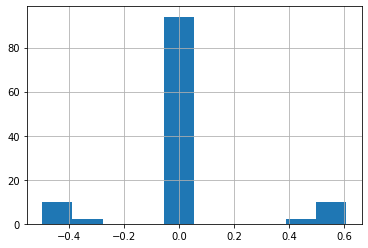

In [34]:
df["diff"].hist();

In most cases there is little or no difference in the probabilities for the target relations.
However, some appear to be off by a substantial (`0.6`) amount, which indicates potential problems in this part of our graph data.

The following rows show where these `foaf:knows` annotations in the graph differs significantly from their truth values predicted by PSL:

In [35]:
df[df["diff"] >= 0.4]

,predicate,p1,p2,truth,diff
4,KNOWS,http://example.org/stuff/person_09,http://example.org/stuff/person_19,0.540282,0.540282
10,KNOWS,http://example.org/stuff/person_06,http://example.org/stuff/person_14,0.506640,0.506640
49,KNOWS,http://example.org/stuff/person_09,http://example.org/stuff/person_06,0.607740,0.607740
60,KNOWS,http://example.org/stuff/person_06,http://example.org/stuff/person_09,0.606501,0.606501
85,KNOWS,http://example.org/stuff/person_18,http://example.org/stuff/person_17,0.560535,0.560535
92,KNOWS,http://example.org/stuff/person_17,http://example.org/stuff/person_18,0.561158,0.561158
94,KNOWS,http://example.org/stuff/person_17,http://example.org/stuff/person_21,0.476654,0.476654
97,KNOWS,http://example.org/stuff/person_01,http://example.org/stuff/person_17,0.578474,0.578474
100,KNOWS,http://example.org/stuff/person_21,http://example.org/stuff/person_17,0.476275,0.476275
107,KNOWS,http://example.org/stuff/person_19,http://example.org/stuff/person_09,0.539336,0.539336


Speaking of [*human-in-the-loop*](https://derwen.ai/d/human-in-the-loop) practices for AI, using PSL along with a KG seems like a great way to leverage machine learning, so that the people can focus on parts of the graph that have the most uncertainty.
And, therefore, probably provide the best ROI for investing time+cost into curation.

---

## Exercises

**Exercise 1:**

Build a PSL model that tests the "noodle vs. pancake" rules used in an earlier example with our recipe KG.
Which recipes should be annotated differently?

**Exercise 2:**

Try representing one of the other [PSL examples](https://github.com/linqs/psl-examples/) using RDF and `kglab`.